In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 38 kB/s 
     |████████████████████████████████| 199 kB 48.8 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=bc92986bb7a868b92506f9eec101705f2ebd5fce73cbd846c3d00b1dff5573a8
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [156]:
from pyspark.sql import SparkSession #we are creating a new spark session 
spark= SparkSession.builder.getOrCreate()
from pyspark import SparkContext

In [157]:
spark

In [158]:
from google.colab import auth #authenticating my existing google collab User for connecting to my Google Cloud Storage
auth.authenticate_user()

In [159]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2426  100  2426    0     0  67388      0 --:--:-- --:--:-- --:--:-- 67388
OK
34 packages can be upgraded. Run 'apt list --upgradable' to see them.
gcsfuse is already the newest version (0.41.9).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [160]:
!mkdir groupbucket
!gcsfuse groupbucket groupbucket

mkdir: cannot create directory ‘groupbucket’: File exists
2022/12/12 03:52:24.804552 Start gcsfuse/0.41.9 (Go version go1.18.4) for app "" using mount point: /content/groupbucket
2022/12/12 03:52:24.826874 Opening GCS connection...
2022/12/12 03:52:25.505589 Mounting file system "groupbucket"...
2022/12/12 03:52:25.506097 File system has been successfully mounted.


In [161]:
from pyspark.sql.types import *
from pyspark.sql.functions import *

In [162]:
path= 'groupbucket/cars.csv'   
ordersSchema = StructType([
  StructField("maker", StringType(), True),
  StructField("model",StringType() , True),
  StructField("mileage", IntegerType(), True),
  StructField("manufacture_year", IntegerType(), True),
  StructField("engine_displacement", IntegerType(), True),
  StructField("engine_power", IntegerType(), True),
  StructField("body_type", StringType(), True),
  StructField("color_slug", StringType(), True),
  StructField("stk_year", IntegerType(), True),
  StructField("transmission", StringType(), True),
  StructField("door_count", IntegerType(), True),
  StructField("seat_count", IntegerType(), True),
  StructField("fuel_type", StringType(), True),
  StructField("date_created", DateType(), True),
  StructField("date_last_seen", DateType(), True),
  StructField("price_eur", DoubleType(), True)])


df1 = spark.read.format("csv") \
      .option("header", True) \
      .schema(ordersSchema) \
      .load(path)

In [163]:
df1.count()

3552912

In [164]:
df1_copy = df1

In [165]:
df1.describe()

DataFrame[summary: string, maker: string, model: string, mileage: string, manufacture_year: string, engine_displacement: string, engine_power: string, body_type: string, color_slug: string, stk_year: string, transmission: string, door_count: string, seat_count: string, fuel_type: string, price_eur: string]

In [166]:
from pyspark.sql.types import IntegerType , DoubleType , cast

In [167]:
df1.withColumn("mileage",col("mileage").cast(DoubleType())) \
    .withColumn("manufacture_year",col("manufacture_year").cast(IntegerType())) \
    .withColumn("engine_displacement",col("engine_displacement").cast(DoubleType())) \
    .withColumn("engine_power",col("engine_power").cast(DoubleType())) \
    .withColumn("stk_year",col("stk_year").cast(IntegerType())) \
    .withColumn("door_count",col("door_count").cast(IntegerType())) \
    .withColumn("seat_count",col("seat_count").cast(IntegerType())) \
    .withColumn("price_eur",col("price_eur").cast(DoubleType())) 

DataFrame[maker: string, model: string, mileage: double, manufacture_year: int, engine_displacement: double, engine_power: double, body_type: string, color_slug: string, stk_year: int, transmission: string, door_count: int, seat_count: int, fuel_type: string, date_created: date, date_last_seen: date, price_eur: double]

In [168]:
missing_df =  df1.select([count(when(col(column).isNull(),column)).alias(column) for column in df1.columns])


In [169]:
missing_df.show()

+------+-------+-------+----------------+-------------------+------------+---------+----------+--------+------------+----------+----------+---------+------------+--------------+---------+
| maker|  model|mileage|manufacture_year|engine_displacement|engine_power|body_type|color_slug|stk_year|transmission|door_count|seat_count|fuel_type|date_created|date_last_seen|price_eur|
+------+-------+-------+----------------+-------------------+------------+---------+----------+--------+------------+----------+----------+---------+------------+--------------+---------+
|518915|1133361| 362584|          370578|             743414|      554877|  1122914|   3343411| 3016807|      741630|   1090066|   1287099|  1847606|           0|             0|        0|
+------+-------+-------+----------------+-------------------+------------+---------+----------+--------+------------+----------+----------+---------+------------+--------------+---------+



In [170]:
from os import name
pd_missing_df = missing_df.toPandas()
pd_missing_df=pd_missing_df.transpose().reset_index().rename(index=str, columns={0: "Missing_Values_Count"})
pd_missing_df

,index,Missing_Values_Count
0,maker,518915
1,model,1133361
2,mileage,362584
3,manufacture_year,370578
4,engine_displacement,743414
5,engine_power,554877
6,body_type,1122914
7,color_slug,3343411
8,stk_year,3016807
9,transmission,741630


**Visualization of Number of missing values in each of the attribute**
---------------

In [171]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [172]:
print(df1.count())

3552912


In [173]:
type(missing_df)

pyspark.sql.dataframe.DataFrame

<Figure size 14400x10800 with 0 Axes>

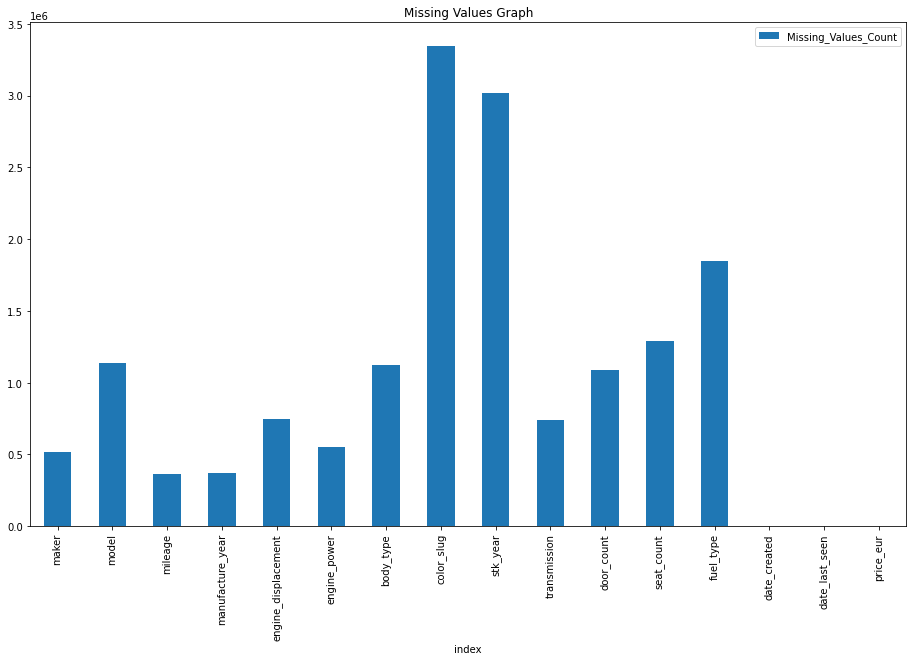

In [174]:
plt.figure(figsize=(200,150), facecolor='grey')
plotnumber = 1
pd_missing_df.plot(x="index", y="Missing_Values_Count", kind="bar",title="Missing Values Graph")



**Grouping pyspark dataframe by price and counting number of occurences for each of the price**
---------------

In [175]:
price_group = df1.groupBy("price_eur").agg(count('price_eur').alias('Count'))

In [176]:
price_group_sorted = price_group.orderBy("Count",ascending=[0])

In [177]:
price_group_sorted.show()

+---------+------+
|price_eur| Count|
+---------+------+
|  1295.34|673623|
|   9900.0|  6609|
|  10900.0|  6497|
|  12900.0|  6274|
|  11900.0|  6169|
|   8900.0|  5935|
|   6900.0|  5657|
|  13900.0|  5597|
|   4900.0|  5557|
|  14900.0|  5556|
|   3500.0|  5523|
|   4500.0|  5484|
|   5500.0|  5335|
|   5900.0|  5305|
|   555.14|  5300|
|   6500.0|  5267|
|   2500.0|  5233|
|  2035.53|  5103|
|   925.24|  4944|
|   7900.0|  4915|
+---------+------+
only showing top 20 rows



In [178]:
price_group_sorted_top= price_group_sorted.limit(10)
price_group_sorted_top.show()


+---------+------+
|price_eur| Count|
+---------+------+
|  1295.34|673623|
|   9900.0|  6609|
|  10900.0|  6497|
|  12900.0|  6274|
|  11900.0|  6169|
|   8900.0|  5935|
|   6900.0|  5657|
|  13900.0|  5597|
|   4900.0|  5557|
|  14900.0|  5556|
+---------+------+



In [179]:
pd_price_group_sorted=price_group_sorted_top.toPandas()
pd_price_group_sorted

,price_eur,Count
0,1295.34,673623
1,9900.00,6609
2,10900.00,6497
3,12900.00,6274
4,11900.00,6169
5,8900.00,5935
6,6900.00,5657
7,13900.00,5597
8,4900.00,5557
9,14900.00,5556


<Figure size 14400x10800 with 0 Axes>

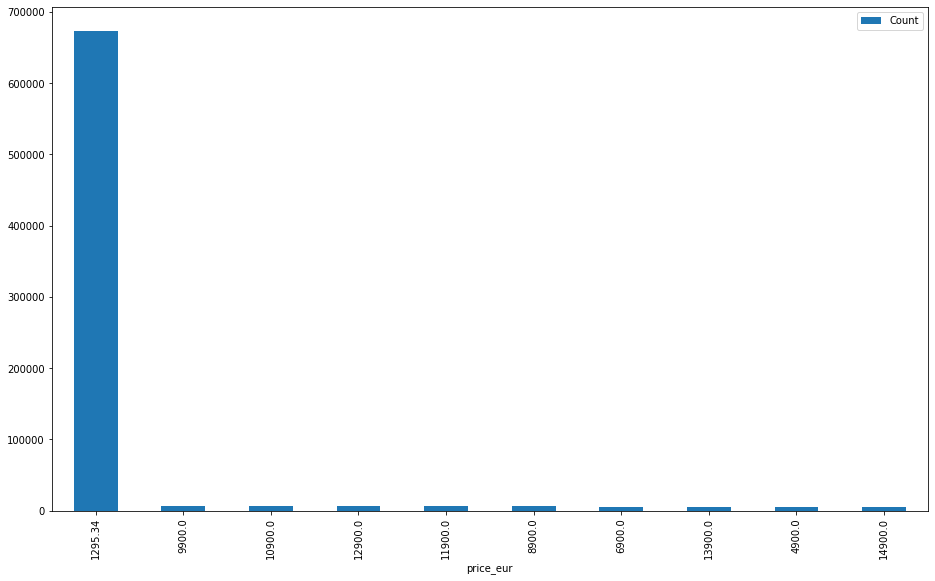

In [180]:
plt.figure(figsize=(200,150), facecolor='grey')
plotnumber = 1
pd_price_group_sorted.plot(x="price_eur", y="Count", kind="bar")

**Finding missing value percentage for each of the columns**
-----------------

In [181]:
missing_df_new= spark.createDataFrame(pd_missing_df)
missing_df_new.show()

+-------------------+--------------------+
|              index|Missing_Values_Count|
+-------------------+--------------------+
|              maker|              518915|
|              model|             1133361|
|            mileage|              362584|
|   manufacture_year|              370578|
|engine_displacement|              743414|
|       engine_power|              554877|
|          body_type|             1122914|
|         color_slug|             3343411|
|           stk_year|             3016807|
|       transmission|              741630|
|         door_count|             1090066|
|         seat_count|             1287099|
|          fuel_type|             1847606|
|       date_created|                   0|
|     date_last_seen|                   0|
|          price_eur|                   0|
+-------------------+--------------------+



In [182]:
row_count= df1.count()

In [183]:
missing_df_new=missing_df_new.withColumn("Percent_missing",round((round((col("Missing_Values_Count")/row_count),2)*100),2))
missing_df_copy = missing_df_new
missing_df_new.show()
missing_df_copy.show()

+-------------------+--------------------+---------------+
|              index|Missing_Values_Count|Percent_missing|
+-------------------+--------------------+---------------+
|              maker|              518915|           15.0|
|              model|             1133361|           32.0|
|            mileage|              362584|           10.0|
|   manufacture_year|              370578|           10.0|
|engine_displacement|              743414|           21.0|
|       engine_power|              554877|           16.0|
|          body_type|             1122914|           32.0|
|         color_slug|             3343411|           94.0|
|           stk_year|             3016807|           85.0|
|       transmission|              741630|           21.0|
|         door_count|             1090066|           31.0|
|         seat_count|             1287099|           36.0|
|          fuel_type|             1847606|           52.0|
|       date_created|                   0|            0.

**Dropping columns with more than 50% missing values**
---------------

In [184]:
drop_columns = missing_df_new.filter(missing_df_new.Percent_missing>50)


In [185]:

drop_col= drop_columns.select("index").toPandas()["index"]
drop_list= list(drop_col)
drop_list


['color_slug', 'stk_year', 'fuel_type']

In [186]:
for i in drop_list:
  df1_copy=df1_copy.drop(i)

In [187]:
df1_copy.show()

+------+-------+-------+----------------+-------------------+------------+---------+------------+----------+----------+------------+--------------+---------+
| maker|  model|mileage|manufacture_year|engine_displacement|engine_power|body_type|transmission|door_count|seat_count|date_created|date_last_seen|price_eur|
+------+-------+-------+----------------+-------------------+------------+---------+------------+----------+----------+------------+--------------+---------+
|  ford| galaxy| 151000|            2011|               2000|         103|     null|         man|         5|         7|  2015-11-14|    2016-01-27| 10584.75|
| skoda|octavia| 143476|            2012|               2000|          81|     null|         man|         5|         5|  2015-11-14|    2016-01-27|  8882.31|
|   bmw|   null|  97676|            2010|               1995|          85|     null|         man|         5|         5|  2015-11-14|    2016-01-27| 12065.06|
| skoda|  fabia| 111970|            2004|           

**Removing rows with Count=1 as these are irrelevant for analysis due to low count**
--------------

In [188]:
price_group_filter=price_group_sorted.filter(price_group_sorted.Count>1)
price_group_filter_new= price_group_filter.drop("Count")

price_group_filter_new.show()
price_group_filter_new=price_group_filter_new.withColumnRenamed("price_eur","price_eur_new")
price_group_filter_new.show()

+---------+
|price_eur|
+---------+
|  1295.34|
|   9900.0|
|  10900.0|
|  12900.0|
|  11900.0|
|   8900.0|
|   6900.0|
|  13900.0|
|   4900.0|
|  14900.0|
|   3500.0|
|   4500.0|
|   5500.0|
|   5900.0|
|   555.14|
|   6500.0|
|   2500.0|
|  2035.53|
|   925.24|
|   7900.0|
+---------+
only showing top 20 rows

+-------------+
|price_eur_new|
+-------------+
|      1295.34|
|       9900.0|
|      10900.0|
|      12900.0|
|      11900.0|
|       8900.0|
|       6900.0|
|      13900.0|
|       4900.0|
|      14900.0|
|       3500.0|
|       4500.0|
|       5500.0|
|       5900.0|
|       555.14|
|       6500.0|
|       2500.0|
|      2035.53|
|       925.24|
|       7900.0|
+-------------+
only showing top 20 rows



In [189]:
joined_df = df1_copy.join(price_group_filter_new,df1_copy.price_eur==price_group_filter_new.price_eur_new,"inner")

In [190]:
joined_df.show()

+-------+-------------+-------+----------------+-------------------+------------+---------+------------+----------+----------+------------+--------------+---------+-------------+
|  maker|        model|mileage|manufacture_year|engine_displacement|engine_power|body_type|transmission|door_count|seat_count|date_created|date_last_seen|price_eur|price_eur_new|
+-------+-------------+-------+----------------+-------------------+------------+---------+------------+----------+----------+------------+--------------+---------+-------------+
|  skoda|        fabia| 111970|            2004|               1200|          47|     null|         man|         5|         5|  2015-11-14|    2016-01-27|  2960.77|      2960.77|
|  skoda|        fabia| 130749|            2004|               1200|          47|     null|         man|         5|         5|  2015-11-14|    2016-01-27|  2960.77|      2960.77|
|   fiat|        stilo|  63588|            2004|               1600|          76|     null|         man| 

In [191]:
joined_df_new=joined_df.groupBy("price_eur").agg(count("price_eur").alias("Count_Value"))


In [192]:
joined_df_new.show()

+---------+-----------+
|price_eur|Count_Value|
+---------+-----------+
|  2960.77|       2250|
| 10173.95|         55|
|  3515.54|         46|
| 16653.96|         59|
|  4440.78|        132|
|   181.35|        120|
| 12657.29|         22|
| 18023.69|         24|
|  1887.49|        347|
|  3993.34|         36|
| 33678.76|          8|
|   795.71|         66|
|     8.51|          9|
|   5014.8|         32|
|  9045.89|          6|
| 32161.36|         31|
|    12.32|          5|
|  2891.27|         37|
|  7498.33|          4|
|  7949.41|          6|
+---------+-----------+
only showing top 20 rows



In [193]:
joined_df_new.filter(joined_df_new.Count_Value<2).show()


+---------+-----------+
|price_eur|Count_Value|
+---------+-----------+
+---------+-----------+



In [194]:
joined_df.count()

3446944

**The final cleaning process involves deleting rows that have missing "maker" or "Model" attributes as these are useful for our analysis. This ends our cleaning process.**
----------------------------

In [195]:
cleaned_data = joined_df.na.drop(subset=["maker","model"])
cleaned_data = cleaned_data.drop("price_eur_new")

In [196]:
cleaned_data_missing= cleaned_data.select([count(when(col(column).isNull(),column)).alias(column) for column in cleaned_data.columns])


In [197]:
cleaned_data_missing.show()

+-----+-----+-------+----------------+-------------------+------------+---------+------------+----------+----------+------------+--------------+---------+
|maker|model|mileage|manufacture_year|engine_displacement|engine_power|body_type|transmission|door_count|seat_count|date_created|date_last_seen|price_eur|
+-----+-----+-------+----------------+-------------------+------------+---------+------------+----------+----------+------------+--------------+---------+
|    0|    0| 233330|          227799|             445108|      319388|   540626|      492827|    698964|    830442|           0|             0|        0|
+-----+-----+-------+----------------+-------------------+------------+---------+------------+----------+----------+------------+--------------+---------+



In [198]:
cleaned_data.count()

2358965

**Introducing a new column "Segment" which will indicate wether the car is "Standard", "Executive" or Luxury based on price**
-------------
Standard cars: less than 18000 Euro
-----------------
Executive Cars: 18000 to 300,000 Euro
-------------
Luxury cars:  more than 300,000 Euro**
---------------

In [46]:
from pyspark.sql.functions import col,lit,when

In [47]:
cleaned_data.withColumn("mileage",col("mileage").cast(DoubleType())) \
    .withColumn("manufacture_year",col("manufacture_year").cast(IntegerType())) \
    .withColumn("engine_displacement",col("engine_displacement").cast(DoubleType())) \
    .withColumn("engine_power",col("engine_power").cast(DoubleType())) \
    .withColumn("door_count",col("door_count").cast(IntegerType())) \
    .withColumn("seat_count",col("seat_count").cast(IntegerType())) \
    .withColumn("price_eur",col("price_eur").cast(DoubleType())) 

DataFrame[maker: string, model: string, mileage: double, manufacture_year: int, engine_displacement: double, engine_power: double, body_type: string, transmission: string, door_count: int, seat_count: int, date_created: date, date_last_seen: date, price_eur: double]

In [48]:
final_data = cleaned_data.withColumn("Segment", when(((col("price_eur")<18000)) ,lit("Standard"))\
                        .when(((col("price_eur")>=18000) & (col("price_eur")<300000)),lit("Executive"))\
                        .when(((col("price_eur")>=300000)),lit("Luxury")))

In [49]:
final_data.show()

+---------+-------------+-------+----------------+-------------------+------------+---------+------------+----------+----------+------------+--------------+---------+--------+
|    maker|        model|mileage|manufacture_year|engine_displacement|engine_power|body_type|transmission|door_count|seat_count|date_created|date_last_seen|price_eur| Segment|
+---------+-------------+-------+----------------+-------------------+------------+---------+------------+----------+----------+------------+--------------+---------+--------+
|    skoda|        fabia| 111970|            2004|               1200|          47|     null|         man|         5|         5|  2015-11-14|    2016-01-27|  2960.77|Standard|
|    skoda|        fabia| 130749|            2004|               1200|          47|     null|         man|         5|         5|  2015-11-14|    2016-01-27|  2960.77|Standard|
|     fiat|        stilo|  63588|            2004|               1600|          76|     null|         man|         5|   

In [50]:
grouped_data = final_data.groupBy("maker","model","price_eur").agg(count("*").alias("Count_cars"))


In [51]:
grouped_data.orderBy(col("Count_cars").desc()).show()

+----------+-------+---------+----------+
|     maker|  model|price_eur|Count_cars|
+----------+-------+---------+----------+
|     skoda|octavia|  1295.34|     65124|
|     skoda|  fabia|  1295.34|     42704|
|volkswagen|   golf|  1295.34|     21341|
|volkswagen| passat|  1295.34|     20267|
|      ford|  focus|  1295.34|     16415|
|     skoda| superb|  1295.34|     12726|
|      ford| mondeo|  1295.34|     11344|
|   renault| megane|  1295.34|      8686|
|      opel|  astra|  1295.34|      8266|
|volkswagen| touran|  1295.34|      7038|
|      audi|     a4|  1295.34|      6871|
|     skoda|felicia|  1295.34|      6539|
|   peugeot|    206|  1295.34|      6257|
|      audi|     a6|  1295.34|      5716|
|volkswagen|   polo|  1295.34|      5536|
|     skoda|  rapid|  1295.34|      5189|
|   peugeot|    307|  1295.34|      4635|
|   renault|   clio|  1295.34|      4567|
|   renault| scenic|  1295.34|      4447|
|      ford| fiesta|  1295.34|      4387|
+----------+-------+---------+----

In [52]:
grouped_data.select("Count_cars").describe().show()

+-------+------------------+
|summary|        Count_cars|
+-------+------------------+
|  count|            725054|
|   mean|3.2535024977449956|
| stddev|108.40388290655633|
|    min|                 1|
|    max|             65124|
+-------+------------------+



In [53]:
final_data_standard= final_data.filter(final_data.Segment=="Standard")

In [54]:
final_data_Executive= final_data.filter(final_data.Segment=="Executive")

In [55]:
final_data_Luxury= final_data.filter(final_data.Segment=="Luxury")

In [56]:
final_data_Luxury.show()

+-----------+-----------+-------+----------------+-------------------+------------+---------+------------+----------+----------+------------+--------------+--------------+-------+
|      maker|      model|mileage|manufacture_year|engine_displacement|engine_power|body_type|transmission|door_count|seat_count|date_created|date_last_seen|     price_eur|Segment|
+-----------+-----------+-------+----------------+-------------------+------------+---------+------------+----------+----------+------------+--------------+--------------+-------+
|    peugeot|        206| 136000|            2004|               1360|          55|    other|         man|         5|         5|  2016-02-23|    2016-07-03|      300000.0| Luxury|
|     jaguar|         xj|  12000|            1992|               null|        null|     null|         man|         2|         2|  2015-12-02|    2016-02-10|     385042.75| Luxury|
|   maserati|     ghibli|  32000|            1971|               null|         246|     null|       

In [57]:
std_final_grouped= final_data_standard.groupBy("maker","model","price_eur").agg(count("*").alias("Count_cars_Standard"))
std_final_grouped.show()

+-------------+-------+---------+-------------------+
|        maker|  model|price_eur|Count_cars_Standard|
+-------------+-------+---------+-------------------+
|          kia|sorento|  4440.78|                  1|
|         mini|    one| 12801.41|                  1|
|      citroen|     c5|  3333.23|                  1|
|        volvo|    v70|  2500.74|                  1|
|         mini| cooper| 11968.76|                  1|
|         fiat|   500l|  8554.74|                  1|
|         audi|     a3|  1350.11|                  2|
|        mazda|      3| 12598.41|                  1|
|      hyundai|    i30|  6328.65|                  2|
|         fiat|   idea|  2150.81|                  1|
|      citroen|     c3|  7472.09|                  1|
|         audi|     s6|  5903.48|                  1|
|         audi|    100|  2999.22|                  1|
|        skoda|octavia| 14174.69|                  6|
|         audi|     a3| 17959.62|                  3|
|         fiat|   qubo|  500

In [58]:
std_final_grouped.select("Count_cars_Standard").describe().show()

+-------+-------------------+
|summary|Count_cars_Standard|
+-------+-------------------+
|  count|             528010|
|   mean|    3.7315619022367|
| stddev| 127.00499214499942|
|    min|                  1|
|    max|              65124|
+-------+-------------------+



In [59]:
final_data_Luxury= final_data_Luxury.withColumn("Days_for_sale", datediff("date_last_seen","date_created"))

In [60]:
lux_final_grouped= final_data_Luxury.groupBy("maker","model").agg(count("*").alias("Count_cars_Luxury"),avg("price_eur").alias("price_eur"),avg("Days_for_sale").alias("Days_for_sale"))
lux_final_grouped.select("Count_cars_Luxury").describe().show()

+-------+------------------+
|summary| Count_cars_Luxury|
+-------+------------------+
|  count|                96|
|   mean|3.3333333333333335|
| stddev| 5.196490043474521|
|    min|                 1|
|    max|                29|
+-------+------------------+



In [61]:
lux_final_grouped.show()

+----------+--------------+-----------------+--------------------+------------------+
|     maker|         model|Count_cars_Luxury|           price_eur|     Days_for_sale|
+----------+--------------+-----------------+--------------------+------------------+
| chevrolet|       captiva|                1|          1000887.23|             136.0|
|    lancia|         delta|                1|            350000.0|             133.0|
|      fiat|         stilo|                1|       2.677111073E7|              60.0|
|volkswagen|   transporter|                2|       2.874229123E7|             142.0|
|      audi|            v8|                1|       2.605812439E7|              33.0|
|      ford|        mondeo|               12| 1.712191784916667E7|27.083333333333332|
|      seat|         ibiza|                1|        9.99999999E8|             130.0|
|     skoda|       octavia|                8|3.3880452021249995E7|            18.375|
|   peugeot|           307|                1|         

In [62]:

luxury_count=lux_final_grouped.withColumn("Maker-Model",concat_ws("-",col("maker"),col("model")))
luxury_count.show()

+----------+--------------+-----------------+--------------------+------------------+--------------------+
|     maker|         model|Count_cars_Luxury|           price_eur|     Days_for_sale|         Maker-Model|
+----------+--------------+-----------------+--------------------+------------------+--------------------+
| chevrolet|       captiva|                1|          1000887.23|             136.0|   chevrolet-captiva|
|    lancia|         delta|                1|            350000.0|             133.0|        lancia-delta|
|      fiat|         stilo|                1|       2.677111073E7|              60.0|          fiat-stilo|
|volkswagen|   transporter|                2|       2.874229123E7|             142.0|volkswagen-transp...|
|      audi|            v8|                1|       2.605812439E7|              33.0|             audi-v8|
|      ford|        mondeo|               12| 1.712191784916667E7|27.083333333333332|         ford-mondeo|
|      seat|         ibiza|          

In [63]:
luxury_count=luxury_count.withColumn("price_eur",col("price_eur").cast(DoubleType())) \
    .withColumn("Days_for_sale",col("Days_for_sale").cast(IntegerType()))
    
    

In [64]:
luxury_count.filter(luxury_count.Count_cars_Luxury<3).count()

66

In [65]:
luxury_count.filter(luxury_count.Count_cars_Luxury>2).count()

30

**Here we can observe that 66 Luxury cars have a Volume/number of cars sold to be less than 3 . The remaining Luxury cars which were sold more than twice is comparatively a lesser number of 30. Hence we are analysing the cars that were sold <3 and cars that were sold >2 separately.**
--------

**Analysis for Luxury Cars sold less <3 .**
--------------------------------------

**We will create a new Column called "Days_count_ratio"** 
---------------------
**Days_count_ratio is the yardstick that we will use to conclude which are the best cars.
-----------------------------------
Days_count_ratio will be a ratio of "days_of_sale" / "exe_count"
---------------------------
We are taking this ratio as it will take into consideration the volume of cars sold as well as the number of days it took for the cars to sell. We are doing this to reduce the bias when cars sold are very few**
-----------------------------------------------------------------------------


In [66]:
luxury_count= luxury_count.withColumn("Days_count_ratio",round((col("Days_for_sale")/col("Count_cars_Luxury")),2))

In [67]:
lux_car_two = luxury_count.filter(col("Count_cars_Luxury")<3)
lux_car_two.count()

66

In [68]:
lux_car_two.show()

+----------+--------------+-----------------+--------------+-------------+--------------------+----------------+
|     maker|         model|Count_cars_Luxury|     price_eur|Days_for_sale|         Maker-Model|Days_count_ratio|
+----------+--------------+-----------------+--------------+-------------+--------------------+----------------+
| chevrolet|       captiva|                1|    1000887.23|          136|   chevrolet-captiva|           136.0|
|    lancia|         delta|                1|      350000.0|          133|        lancia-delta|           133.0|
|      fiat|         stilo|                1| 2.677111073E7|           60|          fiat-stilo|            60.0|
|volkswagen|   transporter|                2| 2.874229123E7|          142|volkswagen-transp...|            71.0|
|      audi|            v8|                1| 2.605812439E7|           33|             audi-v8|            33.0|
|      seat|         ibiza|                1|  9.99999999E8|          130|          seat-ibiza| 

In [69]:
pd_lux_count_two= lux_car_two.toPandas()
pd_lux_count_two=pd_lux_count_two.sort_values(by=["Days_count_ratio"],ascending=True)
pd_lux_count_two_plot= pd_lux_count_two.head(7)


[Text(0.5, 1.0, 'Days_count_ratio vs Maker-Model for Top Luxury Cars sold less than 3')]

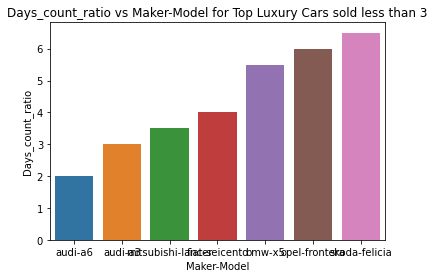

In [70]:
sns.barplot(data=pd_lux_count_two_plot, x="Maker-Model", y="Days_count_ratio").set(title='Days_count_ratio vs Maker-Model for Top Luxury Cars sold less than 3')

**Here we can conclude that:**
-----
**In Luxury Segment: for make and model of cars which are sold less than 3**
----------
**The top 5 cars are :** 
------
**1. audi-a6**
---------
**2. audi-a3**
-----
**3. mitsubishi - lancer**
------
**4. fiat-seicento**
-------
**5. bmw-x5**
--------------
**In this category since we have two audi cars, we can conclude that audi is the best make in this category**
-----------------

**Analysing cars that were sold more than two times**
--------------------------------------------------------------

In [71]:
luxury_count_f = luxury_count.filter(col("Count_cars_Luxury")>2)
luxury_count_f.count()

30

In [72]:
pd_lux_count= luxury_count_f.toPandas()
pd_lux_count=pd_lux_count.sort_values(by=["Days_count_ratio"],ascending=True)
pd_lux_count_plot= pd_lux_count.head(7)


In [73]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 15.7,9.27

[Text(0.5, 1.0, 'Days_count_ratio vs maker-model for Top Luxury Cars')]

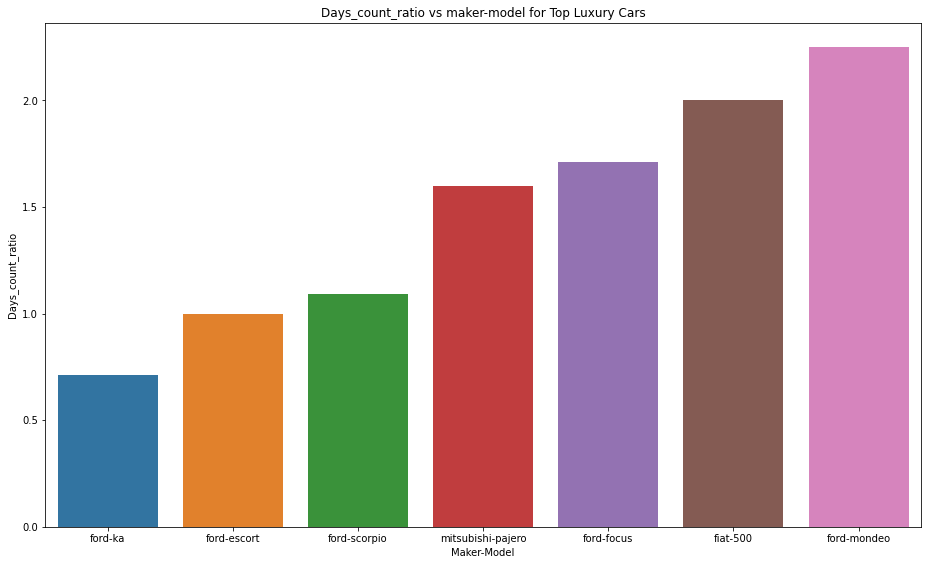

In [74]:
sns.barplot(data=pd_lux_count_plot, x="Maker-Model", y="Days_count_ratio").set(title='Days_count_ratio vs maker-model for Top Luxury Cars')

***Here we can see the top 5 make and models. We have based it on the average time it takes for the car to be available for sale(date_created) and sold date("last_seen"). We have removed cars which had only one quantity to be sold in market as they could have a bias and also it shows that the demand for such cars was not very high ***
------

**As per the above analysis the best make and model for Luxury cars segment are :** 
---
1. Ford-ka
2. ford-escort
3. ford-scorpio
4. mitsubishi-pajero
5. ford-focus

**Also we can observe that Ford is the best maker in this category**
------

**Analysis for Executive Segment cars**
-----

In [75]:
final_data_Executive= final_data_Executive.withColumn("Days_for_sale", datediff("date_last_seen","date_created"))

In [76]:
exe_final_grouped= final_data_Executive.groupBy("maker","model").agg(count("*").alias("Exe_count"),round(avg("Days_for_sale"),2).alias("Days_for_sale"),round(avg("price_eur"),2).alias("price_eur"))
exe_final_grouped.show()

+----------+------------+---------+-------------+---------+
|     maker|       model|Exe_count|Days_for_sale|price_eur|
+----------+------------+---------+-------------+---------+
|      fiat| cinquecento|        3|        67.33| 29970.52|
|     volvo|         850|        1|         68.0| 18911.18|
|volkswagen|      beetle|     1237|       126.39| 23608.71|
|    toyota|        aygo|        5|         68.4| 48846.72|
|   peugeot|         406|        1|        137.0|  18000.0|
| chevrolet|     captiva|      189|        68.37| 19706.08|
|       kia|      cerato|        1|          9.0| 18001.33|
|    jaguar|         xjs|       65|         93.8| 26305.06|
|      audi|         sq5|      820|        84.75| 59268.67|
|      audi|          s3|     1065|        88.56|  33242.8|
|    nissan|       350-z|       17|        117.0| 22480.81|
|    toyota|      celica|        5|        109.4| 51676.93|
|   peugeot|         301|        1|        132.0|  21900.0|
|      audi|          s6|      206|     

In [77]:
total_exe_cars= exe_final_grouped.count()
total_exe_cars

621

In [78]:
exe_final_grouped.describe().show()

+-------+----------+-----------------+------------------+------------------+------------------+
|summary|     maker|            model|         Exe_count|     Days_for_sale|         price_eur|
+-------+----------+-----------------+------------------+------------------+------------------+
|  count|       621|              621|               621|               621|               621|
|   mean|  Infinity|580.7532467532468| 625.3510466988728| 92.22198067632847| 34494.66742351043|
| stddev|       NaN|947.8447873693599|1732.4179222152525|28.175822873857317|22717.391425154274|
|    min|alfa-romeo|              100|                 1|               1.0|           18000.0|
|    max|     volvo|           zafira|             21887|             171.0|         281944.95|
+-------+----------+-----------------+------------------+------------------+------------------+



In [79]:
exe_final_grouped.filter(exe_final_grouped.Exe_count>2).count()

512

In [80]:
exe_final_grouped.filter(exe_final_grouped.Exe_count>2).count()/total_exe_cars

0.8244766505636071

**The total rows we get for make and model group are : 621**
--
The number of rows of data which has a Exe_count greater than 2 comes out to be 80%**
-----
Hence we will do an analysis on cars which have an exe_count equal to and less than 2 separately.**
------

It is Important that volume of sales and number of days it took for the sales to complete be given equal importance. For this purpose we have created a new factor - Days_count_ratio. **The lower the value of Days_Count_ratio the better the car is overall .**

In [81]:
exe_count=exe_final_grouped.withColumn("Maker-Model",concat_ws("-",col("maker"),col("model")))
exe_count=exe_count.withColumn("Days_count_ratio",round((col("Days_for_sale")/col("Exe_count")),2))
exe_count.show()

+----------+------------+---------+-------------+---------+--------------------+----------------+
|     maker|       model|Exe_count|Days_for_sale|price_eur|         Maker-Model|Days_count_ratio|
+----------+------------+---------+-------------+---------+--------------------+----------------+
|      fiat| cinquecento|        3|        67.33| 29970.52|    fiat-cinquecento|           22.44|
|     volvo|         850|        1|         68.0| 18911.18|           volvo-850|            68.0|
|volkswagen|      beetle|     1237|       126.39| 23608.71|   volkswagen-beetle|             0.1|
|    toyota|        aygo|        5|         68.4| 48846.72|         toyota-aygo|           13.68|
|   peugeot|         406|        1|        137.0|  18000.0|         peugeot-406|           137.0|
| chevrolet|     captiva|      189|        68.37| 19706.08|   chevrolet-captiva|            0.36|
|       kia|      cerato|        1|          9.0| 18001.33|          kia-cerato|             9.0|
|    jaguar|        

In [82]:
exe_count=exe_count.withColumn("price_eur",col("price_eur").cast(DoubleType())) \
    .withColumn("Days_for_sale",col("Days_for_sale").cast(IntegerType()))

In [83]:
exe_cars_other = exe_count.filter(exe_count.Exe_count<3) # This is the analysis done for exe_count or the cars for which the volume sold was less than 3

**Analysis for cars sold only once**

In [84]:
exe_cars_other.show()

+----------+---------+---------+-------------+---------+------------------+----------------+
|     maker|    model|Exe_count|Days_for_sale|price_eur|       Maker-Model|Days_count_ratio|
+----------+---------+---------+-------------+---------+------------------+----------------+
|     volvo|      850|        1|           68| 18911.18|         volvo-850|            68.0|
|   peugeot|      406|        1|          137|  18000.0|       peugeot-406|           137.0|
|       kia|   cerato|        1|            9| 18001.33|        kia-cerato|             9.0|
|   peugeot|      301|        1|          132|  21900.0|       peugeot-301|           132.0|
|    jaguar|   x-type|        2|           98|  36954.2|     jaguar-x-type|           49.25|
|      jeep|scrambler|        1|           44| 18805.55|    jeep-scrambler|            44.0|
|    lancia|   thesis|        1|          158| 18134.72|     lancia-thesis|           158.0|
|     honda|    s2000|        2|           13| 19220.38|       honda-s

In [85]:
pd_exe_count_one= exe_cars_other.toPandas()
pd_exe_count_one=pd_exe_count_one.sort_values(by=["Days_count_ratio"],ascending=True)
pd_exe_count_one_plot= pd_exe_count_one.head(20)
pd_exe_count_one_plot

,maker,model,Exe_count,Days_for_sale,price_eur,Maker-Model,Days_count_ratio
49,mazda,323,1,1,100036.01,mazda-323,1.00
23,jeep,liberty,1,1,23002.55,jeep-liberty,1.00
63,subaru,justy,1,2,20355.29,subaru-justy,2.00
18,mitsubishi,colt,1,6,123465.14,mitsubishi-colt,6.00
7,honda,s2000,2,13,19220.38,honda-s2000,6.75
91,alfa-romeo,mito,1,7,24056.25,alfa-romeo-mito,7.00
14,dodge,caravan,1,8,62900.00,dodge-caravan,8.00
89,nissan,tiida,1,8,24981.50,nissan-tiida,8.00
95,chevrolet,spark,2,17,20355.29,chevrolet-spark,8.50
2,kia,cerato,1,9,18001.33,kia-cerato,9.00


In [86]:
pd_exe_count_one_plot= pd_exe_count_one.head(7)

[Text(0.5, 1.0, 'Days_for_Sale vs Maker-model for Top Executive cars')]

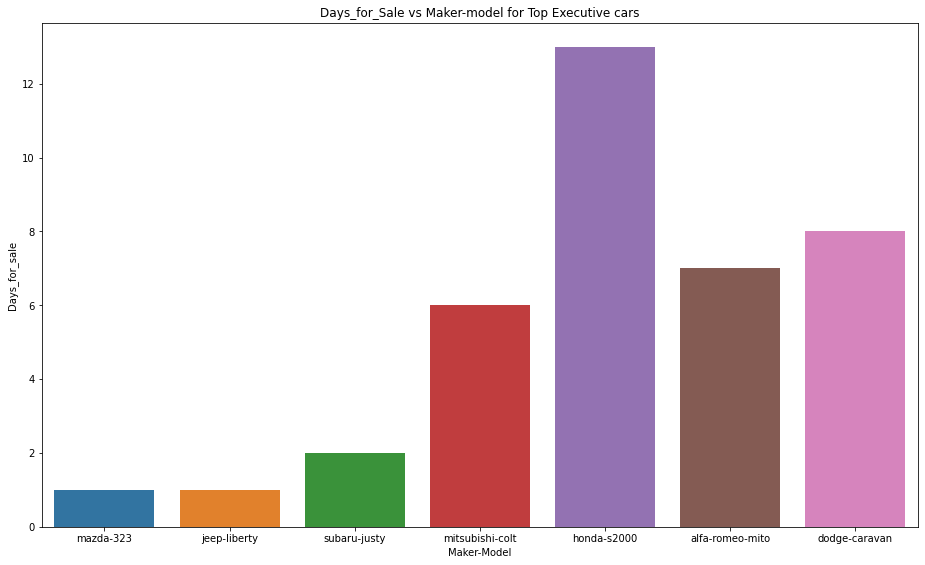

In [87]:
sns.barplot(data=pd_exe_count_one_plot, x="Maker-Model", y="Days_for_sale").set(title='Days_for_Sale vs Maker-model for Top Executive cars')

**Comparing cars with make and model that were available only in one and two in quantity - we can conclude that - "Jeep-liberty" and "Mazda-323" are the best make and model.**


The top maker model in this Category:
 1. Mazda-323 and Jeep-Liberty
 2. Subaru-justy
 3. Mitsubishi-colt
 4. Honda-s2000
 5. alfa-romeo mito
 6. dodge-Caravan

**Now we will analyse cars that were sold more than twice**
----

In [89]:
exe_cars_overall = exe_count.filter(exe_count.Exe_count>2)

In [90]:
pd_exe_count_other= exe_cars_overall.toPandas()
pd_exe_count_other=pd_exe_count_other.sort_values(by=["Days_count_ratio"],ascending=[True])
pd_exe_count_other_plot= pd_exe_count_other.head(30)
pd_exe_count_other_plot

,maker,model,Exe_count,Days_for_sale,price_eur,Maker-Model,Days_count_ratio
235,audi,a3,21887,82,25364.11,audi-a3,0.00
238,ford,kuga,6520,86,23917.38,ford-kuga,0.01
159,seat,leon,7967,95,22554.96,seat-leon,0.01
371,bmw,x1,7451,88,25522.18,bmw-x1,0.01
362,audi,q3,8252,89,30774.52,audi-q3,0.01
28,bmw,x3,6913,83,32016.79,bmw-x3,0.01
27,skoda,octavia,9820,98,23903.68,skoda-octavia,0.01
162,audi,a5,8189,91,28470.16,audi-a5,0.01
351,audi,q5,7474,91,30782.56,audi-q5,0.01
279,nissan,qashqai,8397,94,22722.94,nissan-qashqai,0.01


In [91]:
pd_exe_count_other_plot= pd_exe_count_other.head(10)

[Text(0.5, 1.0, 'Days_for_Sale vs Maker-model for top Executive cars')]

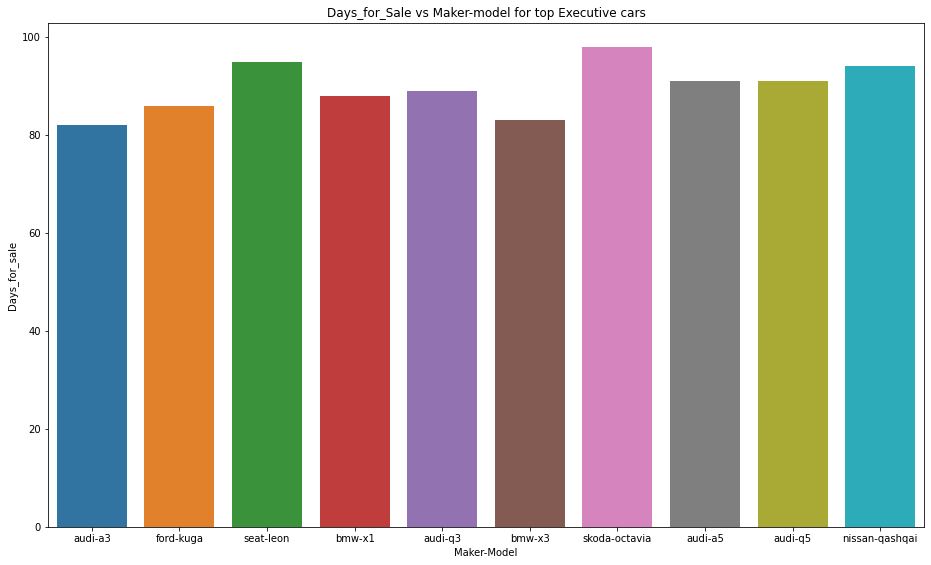

In [92]:
sns.barplot(data=pd_exe_count_other_plot, x="Maker-Model", y="Days_for_sale").set(title='Days_for_Sale vs Maker-model for top Executive cars')

We can conclude that, 
**For Executive class:** 
1. "Audi-A3" is the best make and model when it comes to cars that were sold more than twice. 
2. ford-kuga, seat-leon , bmw-x1 , audi-q3 , bmw-x3 , skoda -octavia , audi-a5 , audi-q5 are make and models that share the second position
3. As per the analysis, we can conclude that Audi is the best maker as they have more models in the best selling list
4. The top maker model in the Category when the sold cars are less than 3:

  Mazda-323 and Jeep-Liberty
  Subaru-justy
  Mitsubishi-colt
  Honda-s2000
  alfa-romeo mito
  dodge-Caravan


**Standard class analysis**

In [93]:
final_data_standard= final_data_standard.withColumn("Days_for_sale", datediff("date_last_seen","date_created"))
final_data_standard.show()

+---------+-------------+-------+----------------+-------------------+------------+---------+------------+----------+----------+------------+--------------+---------+--------+-------------+
|    maker|        model|mileage|manufacture_year|engine_displacement|engine_power|body_type|transmission|door_count|seat_count|date_created|date_last_seen|price_eur| Segment|Days_for_sale|
+---------+-------------+-------+----------------+-------------------+------------+---------+------------+----------+----------+------------+--------------+---------+--------+-------------+
|    skoda|        fabia| 111970|            2004|               1200|          47|     null|         man|         5|         5|  2015-11-14|    2016-01-27|  2960.77|Standard|           74|
|    skoda|        fabia| 130749|            2004|               1200|          47|     null|         man|         5|         5|  2015-11-14|    2016-01-27|  2960.77|Standard|           74|
|     fiat|        stilo|  63588|            2004|

In [94]:
std_final_grouped= final_data_standard.groupBy("maker","model").agg(count("*").alias("Exe_count"),round(avg("Days_for_sale"),2).alias("Days_for_sale"),round(avg("price_eur"),2).alias("price_eur"))


In [95]:
std_final_grouped=std_final_grouped.withColumn("Maker-Model",concat_ws("-",col("maker"),col("model")))
std_final_grouped=std_final_grouped.withColumn("Days_count_ratio",round((col("Days_for_sale")/col("Exe_count")),5))
std_final_grouped.show()

+----------+-----------+---------+-------------+---------+-----------------+----------------+
|     maker|      model|Exe_count|Days_for_sale|price_eur|      Maker-Model|Days_count_ratio|
+----------+-----------+---------+-------------+---------+-----------------+----------------+
|    toyota|       aygo|     7376|        84.59|  6723.72|      toyota-aygo|         0.01147|
|     volvo|        850|      503|        72.83|  1664.26|        volvo-850|         0.14479|
|      fiat|cinquecento|      444|        82.39|  1960.39| fiat-cinquecento|         0.18556|
|   peugeot|        406|     2399|        52.08|  1426.65|      peugeot-406|         0.02171|
|volkswagen|     beetle|     1099|       105.34| 10189.71|volkswagen-beetle|         0.09585|
|       kia|     cerato|      441|        49.99|  2420.84|       kia-cerato|         0.11336|
| chevrolet|    captiva|     2409|        75.33|  9489.17|chevrolet-captiva|         0.03127|
|    jaguar|        xjs|       43|        78.47|  9266.05|  

In [96]:
std_final_grouped.describe().show()

+-------+----------+-----------------+------------------+------------------+------------------+--------------+------------------+
|summary|     maker|            model|         Exe_count|     Days_for_sale|         price_eur|   Maker-Model|  Days_count_ratio|
+-------+----------+-----------------+------------------+------------------+------------------+--------------+------------------+
|  count|      1156|             1156|              1156|              1156|              1156|          1156|              1156|
|   mean|  Infinity|515.6027397260274|1704.4134948096885| 53.79770761245667| 4084.018088235246|          null|  6.91843209342561|
| stddev|       NaN|762.2996738947407| 6556.010588774963|30.823584398530063|3443.4384027284877|          null|19.381090735909353|
|    min|alfa-romeo|              100|                 1|               0.0|             370.1|alfa-romeo-145|               0.0|
|    max|     volvo|               zx|            118457|             168.0|          1750

**There is a huge variation in Exe_count as per this analysis.**
----- 

In [97]:
std_final_grouped.filter(std_final_grouped.Exe_count<6).count()

249

In [98]:
249/1156

0.21539792387543252

**We can observe that more than 80% of data lies in the category when "Exe_count" value is more than 5. Hence we will be doing our analysis separately for these two categories of cars data.**

**Analysis for cars which were sold less than 6 times in Standard Segment of Cars**
-----

In [99]:
std_final_grouped_five= std_final_grouped.filter(std_final_grouped.Exe_count<6)

In [100]:
std_final_grouped_five.show()

+----------+----------+---------+-------------+---------+------------------+----------------+
|     maker|     model|Exe_count|Days_for_sale|price_eur|       Maker-Model|Days_count_ratio|
+----------+----------+---------+-------------+---------+------------------+----------------+
|    subaru|      baja|        3|        37.67|  5983.09|       subaru-baja|        12.55667|
|      jeep| scrambler|        1|        135.0|   8950.0|    jeep-scrambler|           135.0|
|   renault|     fuego|        2|        131.5|   4224.5|     renault-fuego|           65.75|
|     volvo|       242|        3|        11.67|  4065.58|         volvo-242|            3.89|
|    toyota|    solara|        1|        134.0|   7400.0|     toyota-solara|           134.0|
|    nissan|     quest|        3|        65.33|   1976.8|      nissan-quest|        21.77667|
|  infinity|      ex35|        3|        105.0| 10526.61|     infinity-ex35|            35.0|
|      audi|   octavia|        2|        131.0| 16676.54|   

In [101]:
pd_std_count_five= std_final_grouped_five.toPandas()
pd_std_count_five=pd_std_count_five.sort_values(by=["Days_count_ratio"],ascending=[True])
pd_std_count_five_plot= pd_std_count_five.head(30)
pd_std_count_five_plot

,maker,model,Exe_count,Days_for_sale,price_eur,Maker-Model,Days_count_ratio
104,bmw,760i,1,0.00,1295.34,bmw-760i,0.00000
34,bentley,arnage,3,0.67,6365.60,bentley-arnage,0.22333
168,mitsubishi,navara,2,1.50,1295.34,mitsubishi-navara,0.75000
233,skoda,astra,2,1.50,1295.34,skoda-astra,0.75000
95,audi,carnival,4,3.75,1295.34,audi-carnival,0.93750
109,mazda,sportage,1,1.00,1295.34,mazda-sportage,1.00000
226,skoda,touran,1,1.00,1295.34,skoda-touran,1.00000
102,bmw,418i,1,1.00,1295.34,bmw-418i,1.00000
170,fiat,siena,1,1.00,1295.34,fiat-siena,1.00000
176,skoda,vectra,2,2.00,1295.34,skoda-vectra,1.00000


[Text(0.5, 1.0, 'Days_for_Sale vs Maker-model for top Standard cars sold less than 6')]

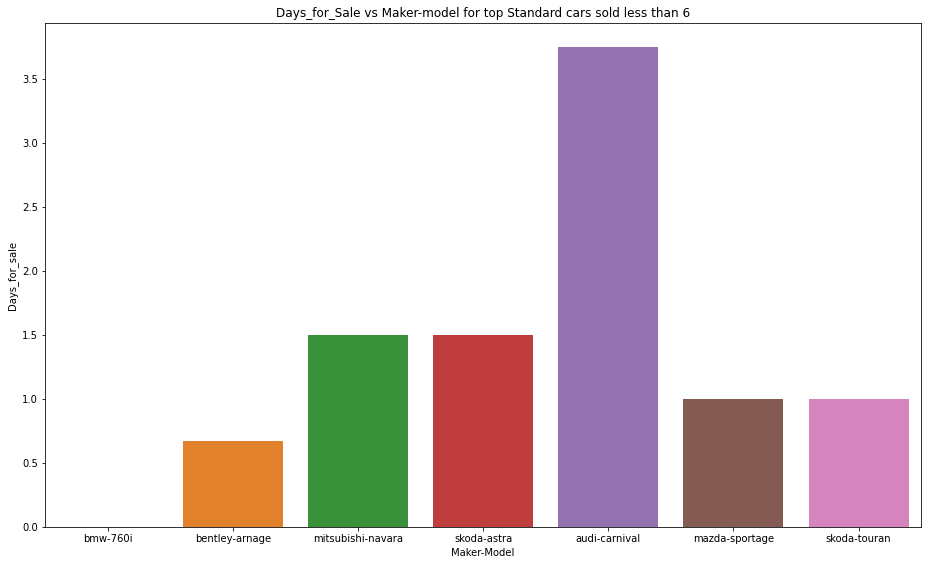

In [102]:
sns.barplot(data=pd_std_count_five_plot.head(7), x="Maker-Model", y="Days_for_sale").set(title='Days_for_Sale vs Maker-model for top Standard cars sold less than 6')

**Here we can conclude that the best make and model in this category are:**

**1.bmw-760i**

**2. bentley-arnage**

**3. mitsubishi-navara**

**4. Skoda-Astra**

**5. Audi-Carnival**

**Analysis for cars which were sold more than 5 times in Standard Segment of Cars**
-----

In [103]:
std_final_grouped_over= std_final_grouped.filter(std_final_grouped.Exe_count>5)
pd_std_count_over= std_final_grouped_over.toPandas()
pd_std_count_over=pd_std_count_over.sort_values(by=["Days_count_ratio"],ascending=[True])
pd_std_count_other_plot= pd_std_count_over.head(30)
pd_std_count_other_plot


,maker,model,Exe_count,Days_for_sale,price_eur,Maker-Model,Days_count_ratio
42,skoda,octavia,118457,42.60,3667.01,skoda-octavia,0.00036
596,skoda,fabia,90085,49.51,3898.44,skoda-fabia,0.00055
127,ford,focus,57202,65.12,5319.04,ford-focus,0.00114
175,volkswagen,golf,71206,91.41,6192.34,volkswagen-golf,0.00128
461,opel,astra,54625,72.14,5992.87,opel-astra,0.00132
63,volkswagen,passat,42389,70.87,4883.73,volkswagen-passat,0.00167
246,opel,corsa,45321,76.81,5477.03,opel-corsa,0.00169
37,ford,mondeo,29842,55.61,3751.78,ford-mondeo,0.00186
593,skoda,superb,22195,42.26,4812.69,skoda-superb,0.00190
709,ford,fiesta,34071,78.78,6219.05,ford-fiesta,0.00231


[Text(0.5, 1.0, 'Days_for_Sale vs Maker-model for top Standard cars sold more than 5')]

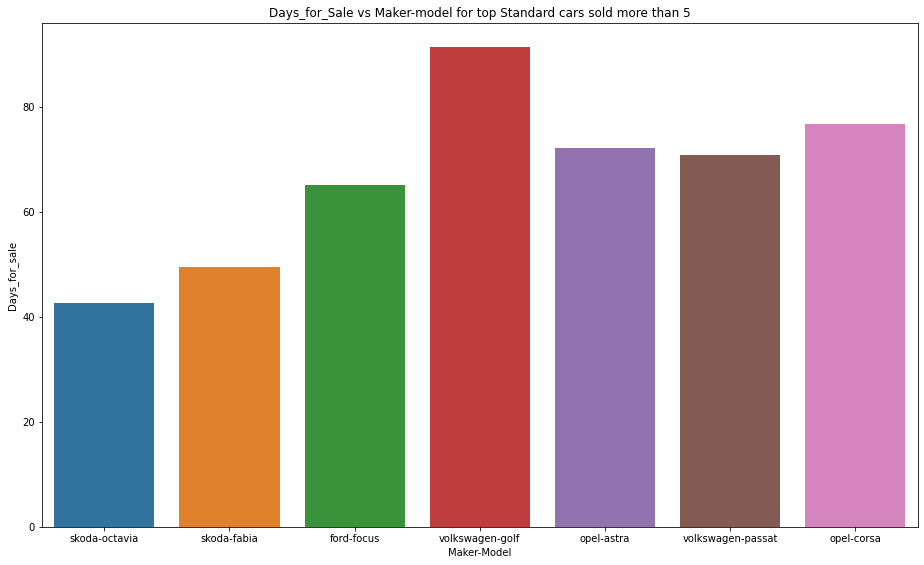

In [104]:
sns.barplot(data=pd_std_count_other_plot.head(7), x="Maker-Model", y="Days_for_sale").set(title='Days_for_Sale vs Maker-model for top Standard cars sold more than 5')

**Here we can conclude that the best cars in the Standard segment for cars which were sold more than 5 in quantity are:**

**1. Skoda-Activa**

**2. Skoda-Fabia**

**3. Ford-Focus**

**4. Volkswagen-Golf**

**5. Opel-Astra**

**ML Model Implementation**
------

**We are using the "cleaned_data" for ML Model implementation**
-----

In [105]:
cleaned_data.show()

+---------+-------------+-------+----------------+-------------------+------------+---------+------------+----------+----------+------------+--------------+---------+
|    maker|        model|mileage|manufacture_year|engine_displacement|engine_power|body_type|transmission|door_count|seat_count|date_created|date_last_seen|price_eur|
+---------+-------------+-------+----------------+-------------------+------------+---------+------------+----------+----------+------------+--------------+---------+
|    skoda|        fabia| 111970|            2004|               1200|          47|     null|         man|         5|         5|  2015-11-14|    2016-01-27|  2960.77|
|    skoda|        fabia| 130749|            2004|               1200|          47|     null|         man|         5|         5|  2015-11-14|    2016-01-27|  2960.77|
|     fiat|        stilo|  63588|            2004|               1600|          76|     null|         man|         5|         5|  2015-11-14|    2016-01-27|  2960.77

In [106]:
cleaned_data.columns

['maker',
 'model',
 'mileage',
 'manufacture_year',
 'engine_displacement',
 'engine_power',
 'body_type',
 'transmission',
 'door_count',
 'seat_count',
 'date_created',
 'date_last_seen',
 'price_eur']

In [107]:
cleaned_data.dtypes

[('maker', 'string'),
 ('model', 'string'),
 ('mileage', 'int'),
 ('manufacture_year', 'int'),
 ('engine_displacement', 'int'),
 ('engine_power', 'int'),
 ('body_type', 'string'),
 ('transmission', 'string'),
 ('door_count', 'int'),
 ('seat_count', 'int'),
 ('date_created', 'date'),
 ('date_last_seen', 'date'),
 ('price_eur', 'double')]

In [108]:
cleaned_data=cleaned_data.withColumn("Current_year", date_format(current_timestamp(),'y'))

In [109]:
cleaned_data.show()

+---------+-------------+-------+----------------+-------------------+------------+---------+------------+----------+----------+------------+--------------+---------+------------+
|    maker|        model|mileage|manufacture_year|engine_displacement|engine_power|body_type|transmission|door_count|seat_count|date_created|date_last_seen|price_eur|Current_year|
+---------+-------------+-------+----------------+-------------------+------------+---------+------------+----------+----------+------------+--------------+---------+------------+
|    skoda|        fabia| 111970|            2004|               1200|          47|     null|         man|         5|         5|  2015-11-14|    2016-01-27|  2960.77|        2022|
|    skoda|        fabia| 130749|            2004|               1200|          47|     null|         man|         5|         5|  2015-11-14|    2016-01-27|  2960.77|        2022|
|     fiat|        stilo|  63588|            2004|               1600|          76|     null|       

New Feature column added : **Age_of_car**

In [110]:
cleaned_data=cleaned_data.withColumn("Age_of_car" ,cleaned_data.Current_year - cleaned_data.manufacture_year)

In [111]:
cleaned_data.show()

+---------+-------------+-------+----------------+-------------------+------------+---------+------------+----------+----------+------------+--------------+---------+------------+----------+
|    maker|        model|mileage|manufacture_year|engine_displacement|engine_power|body_type|transmission|door_count|seat_count|date_created|date_last_seen|price_eur|Current_year|Age_of_car|
+---------+-------------+-------+----------------+-------------------+------------+---------+------------+----------+----------+------------+--------------+---------+------------+----------+
|    skoda|        fabia| 111970|            2004|               1200|          47|     null|         man|         5|         5|  2015-11-14|    2016-01-27|  2960.77|        2022|      18.0|
|    skoda|        fabia| 130749|            2004|               1200|          47|     null|         man|         5|         5|  2015-11-14|    2016-01-27|  2960.77|        2022|      18.0|
|     fiat|        stilo|  63588|            

**Listing the distinct values of categorical columns**

In [112]:
cleaned_data.groupBy('maker').count().show()

+-----------+------+
|      maker| count|
+-----------+------+
|     jaguar|  7109|
|     hummer|   599|
|   infinity|   488|
| mitsubishi| 25181|
|      lexus|  3320|
|     toyota| 64081|
|       seat| 71960|
|    peugeot| 89533|
|   chrysler|  7946|
|    citroen|117048|
|lamborghini|   217|
|      tesla|   149|
|      lotus|   167|
|       audi|192003|
|        bmw| 63530|
|     lancia| 12631|
|       jeep| 15201|
|      dodge|  4320|
|    bentley|   532|
|      skoda|299436|
+-----------+------+
only showing top 20 rows



In [113]:
cleaned_data.groupBy('model').count().show()

+-------------+-----+
|        model|count|
+-------------+-----+
|          xk8|  140|
|        viano| 3603|
|    punto-evo| 2585|
|         hr-v| 1274|
|      4runner|   30|
|        vivio|   22|
|          125|  157|
|          944|  192|
|    el-camino|   57|
|          800|   43|
|        sigma|    8|
|        viper|   79|
|         3200|   93|
|           z1|   35|
|          rcz|  504|
|          124| 1166|
|       antara| 2150|
|     sportage|11598|
|     pacifica|   48|
|micro-compact|   42|
+-------------+-----+
only showing top 20 rows



In [114]:
cleaned_data.groupBy('transmission').count().show()

+------------+-------+
|transmission|  count|
+------------+-------+
|         man|1447969|
|        auto| 418169|
|        null| 492827|
+------------+-------+



In [115]:
import pyspark.ml

In [116]:
from pyspark.ml.feature import VectorAssembler,StringIndexer # Loading Machine learning packages

**label  encoding for the categorical columns**
-----

In [117]:
makerEncod = StringIndexer(inputCol='maker', outputCol='maker_new', handleInvalid="skip" ).fit(cleaned_data)

In [118]:
cleaned_data = makerEncod.transform(cleaned_data )

In [119]:
cleaned_data.show(5)

+-----+------+-------+----------------+-------------------+------------+---------+------------+----------+----------+------------+--------------+---------+------------+----------+---------+
|maker| model|mileage|manufacture_year|engine_displacement|engine_power|body_type|transmission|door_count|seat_count|date_created|date_last_seen|price_eur|Current_year|Age_of_car|maker_new|
+-----+------+-------+----------------+-------------------+------------+---------+------------+----------+----------+------------+--------------+---------+------------+----------+---------+
|skoda| fabia| 111970|            2004|               1200|          47|     null|         man|         5|         5|  2015-11-14|    2016-01-27|  2960.77|        2022|      18.0|      0.0|
|skoda| fabia| 130749|            2004|               1200|          47|     null|         man|         5|         5|  2015-11-14|    2016-01-27|  2960.77|        2022|      18.0|      0.0|
| fiat| stilo|  63588|            2004|           

In [120]:
modelEncod = StringIndexer(inputCol='model', outputCol='model_new',handleInvalid="skip").fit(cleaned_data)

In [121]:
cleaned_data = modelEncod.transform(cleaned_data )

In [122]:
cleaned_data.show(5)

+-----+------+-------+----------------+-------------------+------------+---------+------------+----------+----------+------------+--------------+---------+------------+----------+---------+---------+
|maker| model|mileage|manufacture_year|engine_displacement|engine_power|body_type|transmission|door_count|seat_count|date_created|date_last_seen|price_eur|Current_year|Age_of_car|maker_new|model_new|
+-----+------+-------+----------------+-------------------+------------+---------+------------+----------+----------+------------+--------------+---------+------------+----------+---------+---------+
|skoda| fabia| 111970|            2004|               1200|          47|     null|         man|         5|         5|  2015-11-14|    2016-01-27|  2960.77|        2022|      18.0|      0.0|      1.0|
|skoda| fabia| 130749|            2004|               1200|          47|     null|         man|         5|         5|  2015-11-14|    2016-01-27|  2960.77|        2022|      18.0|      0.0|      1.0|


In [123]:
transmissionEncod = StringIndexer(inputCol='transmission', outputCol='transmission_new',handleInvalid="skip").fit(cleaned_data)

In [124]:
cleaned_data = transmissionEncod.transform(cleaned_data )

In [125]:
cleaned_data.show(5)

+-----+------+-------+----------------+-------------------+------------+---------+------------+----------+----------+------------+--------------+---------+------------+----------+---------+---------+----------------+
|maker| model|mileage|manufacture_year|engine_displacement|engine_power|body_type|transmission|door_count|seat_count|date_created|date_last_seen|price_eur|Current_year|Age_of_car|maker_new|model_new|transmission_new|
+-----+------+-------+----------------+-------------------+------------+---------+------------+----------+----------+------------+--------------+---------+------------+----------+---------+---------+----------------+
|skoda| fabia| 111970|            2004|               1200|          47|     null|         man|         5|         5|  2015-11-14|    2016-01-27|  2960.77|        2022|      18.0|      0.0|      1.0|             0.0|
|skoda| fabia| 130749|            2004|               1200|          47|     null|         man|         5|         5|  2015-11-14|  

In [126]:
print(cleaned_data.columns)

['maker', 'model', 'mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 'body_type', 'transmission', 'door_count', 'seat_count', 'date_created', 'date_last_seen', 'price_eur', 'Current_year', 'Age_of_car', 'maker_new', 'model_new', 'transmission_new']


In [127]:
new_features =['Age_of_car', 'maker_new', 'model_new', 'transmission_new','mileage','engine_displacement', 'engine_power','door_count', 'seat_count']

In [127]:
cleaned_data.printSchema()

In [128]:
new_data =cleaned_data.select('price_eur', 'Age_of_car', 'maker_new', 'model_new', 'transmission_new','mileage','engine_displacement', 'engine_power','door_count', 'seat_count')

In [129]:
new_data.count()

1866138

In [130]:

for col_name in new_features:
    new_data = new_data.withColumn(col_name, col(col_name).cast('float'))

In [131]:
vector_assembler = VectorAssembler(inputCols=new_features,outputCol='features')

In [132]:
vector_data =vector_assembler.setHandleInvalid("skip").transform(new_data)

In [133]:
vector_data.show()

+---------+----------+---------+---------+----------------+--------+-------------------+------------+----------+----------+--------------------+
|price_eur|Age_of_car|maker_new|model_new|transmission_new| mileage|engine_displacement|engine_power|door_count|seat_count|            features|
+---------+----------+---------+---------+----------------+--------+-------------------+------------+----------+----------+--------------------+
|  2960.77|      18.0|      0.0|      1.0|             0.0|111970.0|             1200.0|        47.0|       5.0|       5.0|[18.0,0.0,1.0,0.0...|
|  2960.77|      18.0|      0.0|      1.0|             0.0|130749.0|             1200.0|        47.0|       5.0|       5.0|[18.0,0.0,1.0,0.0...|
|  2960.77|      18.0|      5.0|     98.0|             0.0| 63588.0|             1600.0|        76.0|       5.0|       5.0|[18.0,5.0,98.0,0....|
|  2960.77|      17.0|      0.0|      1.0|             0.0| 79348.0|             1200.0|        47.0|       5.0|       5.0|[17.0,0

In [134]:
final_data = vector_data.select("features","price_eur")

In [135]:
final_data.show()

+--------------------+---------+
|            features|price_eur|
+--------------------+---------+
|[18.0,0.0,1.0,0.0...|  2960.77|
|[18.0,0.0,1.0,0.0...|  2960.77|
|[18.0,5.0,98.0,0....|  2960.77|
|[17.0,0.0,1.0,0.0...|  2960.77|
|[11.0,2.0,9.0,0.0...| 10173.95|
|[18.0,0.0,1.0,0.0...|  2960.77|
|[11.0,2.0,9.0,0.0...| 10173.95|
|[17.0,22.0,157.0,...|  2960.77|
|[10.0,31.0,589.0,...| 16653.96|
|[18.0,14.0,127.0,...|  2960.77|
|[11.0,0.0,12.0,1....| 12657.29|
|[16.0,0.0,1.0,0.0...|  2960.77|
|[19.0,0.0,0.0,0.0...|  2960.77|
|[17.0,0.0,0.0,0.0...|  2960.77|
|[15.0,0.0,1.0,0.0...|  2960.77|
|[14.0,23.0,193.0,...|  2960.77|
|[21.0,15.0,243.0,...|  2960.77|
|[17.0,0.0,1.0,0.0...|  2960.77|
|[20.0,0.0,1.0,0.0...|  2960.77|
|[19.0,0.0,1.0,0.0...|  2960.77|
+--------------------+---------+
only showing top 20 rows



**Splitting the data into test and training**
------

In [136]:
train_data,test_data = final_data.randomSplit([0.7,0.3])

In [137]:
train_data.show()

+--------------------+---------+
|            features|price_eur|
+--------------------+---------+
|[6.0,0.0,0.0,0.0,...| 16284.23|
|[6.0,0.0,0.0,0.0,...| 20318.28|
|[6.0,0.0,0.0,0.0,...|  18900.0|
|[6.0,0.0,0.0,0.0,...|  17989.0|
|[6.0,0.0,0.0,0.0,...| 17770.32|
|[6.0,0.0,0.0,0.0,...| 17770.32|
|[6.0,0.0,0.0,0.0,...| 18083.72|
|[6.0,0.0,0.0,0.0,...| 18924.87|
|[6.0,0.0,0.0,0.0,...|  19250.0|
|[6.0,0.0,0.0,0.0,...| 19332.72|
|[6.0,0.0,0.0,0.0,...|  19390.0|
|[6.0,0.0,0.0,0.0,...|  20884.0|
|[6.0,0.0,0.0,0.0,...|  21145.0|
|[6.0,0.0,0.0,0.0,...|  21245.0|
|[6.0,0.0,0.0,0.0,...|  21490.0|
|[6.0,0.0,0.0,0.0,...|  21490.0|
|[6.0,0.0,0.0,0.0,...|  21544.0|
|[6.0,0.0,0.0,0.0,...|  21544.0|
|[6.0,0.0,0.0,0.0,...|  21544.0|
|[6.0,0.0,0.0,0.0,...|  21644.0|
+--------------------+---------+
only showing top 20 rows



**Implementing ML models**
---- 

In [138]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier

In [139]:
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, DecisionTreeRegressor

**1.Linear Regression**
-----

In [140]:
Lregression = LinearRegression(featuresCol="features",labelCol="price_eur")

In [141]:
Lregression =Lregression.fit(train_data)

In [142]:
print(Lregression.coefficients)
print(Lregression.intercept)


[-472.7506029457637,36.676723317936826,-3.532086176878233,1699.5600167564978,-0.030419077862575798,-0.19648783816600005,156.6800345926658,-902.2976162258378,-142.9833275775955]
10177.407120732867


In [143]:
Lresults = Lregression.evaluate(test_data)

In [144]:
Lresults.predictions.show()

+--------------------+---------+------------------+
|            features|price_eur|        prediction|
+--------------------+---------+------------------+
|[6.0,0.0,0.0,0.0,...| 17770.32|19977.499671218626|
|[6.0,0.0,0.0,0.0,...| 17770.32|19977.499671218626|
|[6.0,0.0,0.0,0.0,...| 18924.87|19977.499671218626|
|[6.0,0.0,0.0,0.0,...|  19250.0|19977.499671218626|
|[6.0,0.0,0.0,0.0,...|  20485.0|19977.499671218626|
|[6.0,0.0,0.0,0.0,...| 20883.53|19977.499671218626|
|[6.0,0.0,0.0,0.0,...|  21490.0|19977.499671218626|
|[6.0,0.0,0.0,0.0,...|  21544.0|19977.499671218626|
|[6.0,0.0,0.0,0.0,...|  21544.0|19977.499671218626|
|[6.0,0.0,0.0,0.0,...|  21584.0|19977.499671218626|
|[6.0,0.0,0.0,0.0,...|  21699.0|19977.499671218626|
|[6.0,0.0,0.0,0.0,...|  22264.0|19977.499671218626|
|[6.0,0.0,0.0,0.0,...|  22366.0|19977.499671218626|
|[6.0,0.0,0.0,0.0,...|  19610.0|19075.202054992784|
|[6.0,0.0,0.0,0.0,...|  19690.0|19075.202054992784|
|[6.0,0.0,0.0,0.0,...| 21428.57|19075.202054992784|
|[6.0,0.0,0.

In [145]:
Lresults.r2,Lresults.rootMeanSquaredError,Lresults.meanSquaredError

(8.149501443344143e-06, 1652378.0586443427, 2730353248689.2466)

In [146]:
#Lregression.save("LinearRegression_model23")

**Random Forest Regression**
----

In [147]:
Randomregression = RandomForestRegressor(featuresCol="features",labelCol="price_eur")

In [148]:

model1 =Randomregression.fit(train_data)

In [149]:
predictions = model1.transform(test_data)

In [150]:
predictions.show()

+--------------------+---------+------------------+
|            features|price_eur|        prediction|
+--------------------+---------+------------------+
|[6.0,0.0,0.0,0.0,...| 17770.32| 17142.08751468077|
|[6.0,0.0,0.0,0.0,...| 17770.32| 17142.08751468077|
|[6.0,0.0,0.0,0.0,...| 18924.87| 17142.08751468077|
|[6.0,0.0,0.0,0.0,...|  19250.0| 17142.08751468077|
|[6.0,0.0,0.0,0.0,...|  20485.0| 17142.08751468077|
|[6.0,0.0,0.0,0.0,...| 20883.53| 17142.08751468077|
|[6.0,0.0,0.0,0.0,...|  21490.0| 17142.08751468077|
|[6.0,0.0,0.0,0.0,...|  21544.0| 17142.08751468077|
|[6.0,0.0,0.0,0.0,...|  21544.0| 17142.08751468077|
|[6.0,0.0,0.0,0.0,...|  21584.0| 17142.08751468077|
|[6.0,0.0,0.0,0.0,...|  21699.0| 17142.08751468077|
|[6.0,0.0,0.0,0.0,...|  22264.0| 17142.08751468077|
|[6.0,0.0,0.0,0.0,...|  22366.0| 17142.08751468077|
|[6.0,0.0,0.0,0.0,...|  19610.0|16993.035721612534|
|[6.0,0.0,0.0,0.0,...|  19690.0|16993.035721612534|
|[6.0,0.0,0.0,0.0,...| 21428.57|16993.035721612534|
|[6.0,0.0,0.

In [151]:
from pyspark.ml.evaluation import RegressionEvaluator

In [152]:

evalator = RegressionEvaluator(labelCol="price_eur",predictionCol="prediction",metricName="rmse")
print("RMSE =", evalator.evaluate(predictions))

RMSE = 1652369.4289839591


In [153]:
evalator = RegressionEvaluator(labelCol="price_eur",predictionCol="prediction",metricName="r2")
print("r2 =",evalator.evaluate(predictions))

r2 = 1.8594529415660865e-05


**Based on root mean squared error, Linear Regression model better fits the data.**
----  

In [199]:
Lregression.save("cars_prediction")